# PREDICTING STUDENTS FINAL MATHEMATICS GRADES

Author: Oluwajolasun Jaiyesimi

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Approach followed for this project

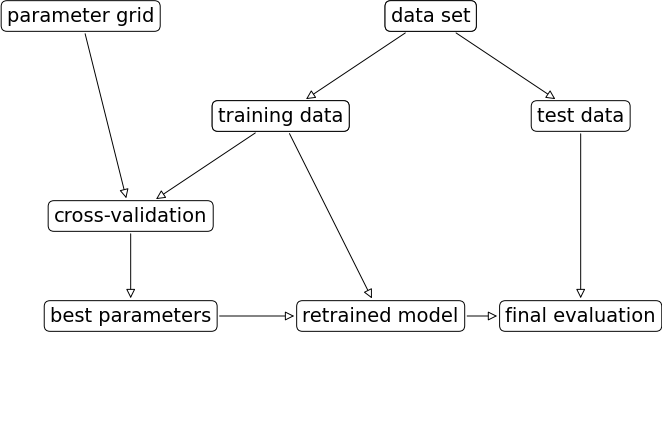

In [2]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## Function Definitions

In [3]:
from sklearn.model_selection import cross_validate

def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)

    val = scores['test_score'].mean()
    train = scores['train_score'].mean()

    return (train, val)

In [4]:
def get_regressor_neg_rms(model, X, y, scoring='nrms', cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms).
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    scores = cross_validate(model, X, y, cv=cv, scoring='scoring', return_train_score=True)
    
    val = scores['test_score'].mean()
    train = scores['train_score'].mean()
    
    return (train, val)

In [5]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    print("Best parameters and their respective values are: ")
    for param in grid_search.best_params_:
        print(f"{param} = {grid_search.best_params_[param]}")
    
    print("Mean training score = {:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_]))
    print("Mean validation score = {:.3f}".format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [6]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [7]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    matrix = confusion_matrix(y_actual, y_pred)
    sns.heatmap(matrix, square= True, annot= True, xticklabels= labels, yticklabels= labels, cbar= False, fmt = 'd')
    plt.title(title)
    plt.xlabel("predicted value")
    plt.ylabel("true value")
    

## Load Data

UCI dataset Visit https://archive.ics.uci.edu/ml/datasets/Student+Performance (33 features, 395 samples)

In [8]:
pd.set_option('display.max_column',100) 
data = pd.read_csv('data\student-mat.csv', sep = ';')
data.head(15)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,14,15,15


In [9]:
print(f"The dataset has a shape of {data.shape}")

The dataset has a shape of (395, 33)


> Data succesfully imported

## Inspecting The data

In [10]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [12]:
data.isnull().any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

>Visually checking for null values using a heatmap

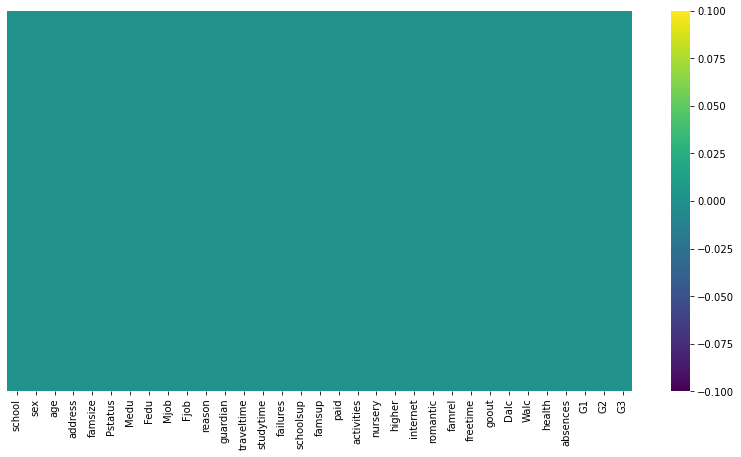

In [13]:
fig_dims = (14, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data.isnull(),cmap="viridis", ax=ax ,yticklabels=False);

> No null values available in this dataset

# Understanding Data

In [14]:
print('Total number of students:', len(data))

Total number of students: 395


In [15]:
female = len(data[data['sex'] == 'F'])
print('Number of female students:',female)
male = len(data[data['sex'] == 'M'])
print('Number of male students:',male)

Number of female students: 208
Number of male students: 187


The male and female student visually represented on a countplot

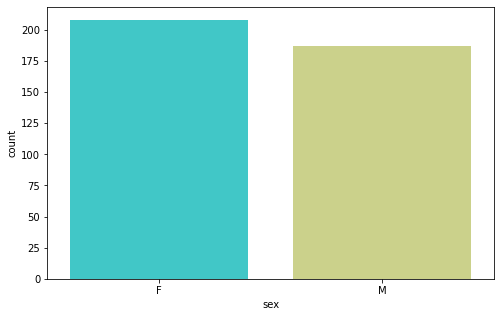

In [16]:
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)   
sns.countplot(x='sex', data=data, ax=ax, palette='rainbow');

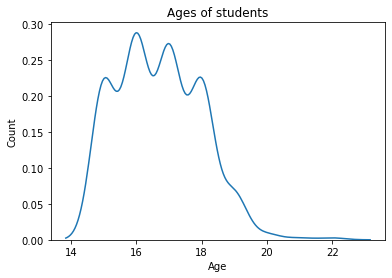

In [17]:
kde = sns.kdeplot(data['age'])    # Kernel Density Estimations
kde.axes.set_title('Ages of students')
kde.set_xlabel('Age')
kde.set_ylabel('Count')
plt.show()

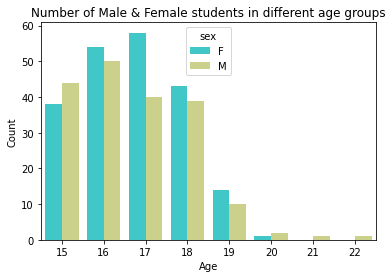

In [18]:
b = sns.countplot(x='age',hue='sex', data=data, palette='rainbow')
b.axes.set_title('Number of Male & Female students in different age groups')
b.set_xlabel("Age")
b.set_ylabel("Count")
plt.show()

In [19]:
urban_area = len(data[data['address'] == 'U'])    # Number of urban areas students
print('Number of Urban students:', urban_area)
rural_area = len(data[data['address'] == 'R'])    # Number of rural areas students
print('Number of Rural students:',rural_area)

Number of Urban students: 307
Number of Rural students: 88


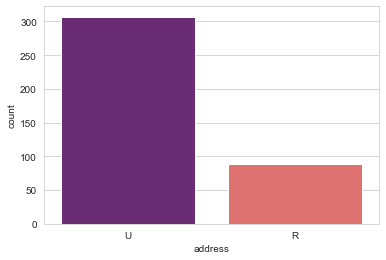

In [20]:
sns.set_style('whitegrid')
sns.countplot(x='address', data=data, palette='magma');

### Correlation Table and Graph

> Correlation between numerical features of the data

In [21]:
data.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,0.019834,-0.047123,-0.046878,0.100285,0.205341,0.215527,0.217147
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.002386,-0.012631,0.014742,0.024473,0.190270,0.164893,0.152457
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.138325,0.134116,0.007501,-0.012944,-0.093040,-0.153198,-0.117142
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.196019,-0.253785,-0.075616,-0.062700,0.160612,0.135880,0.097820
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.354718,-0.355896,-0.360415
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.022168,-0.018281,0.051363
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.012613,-0.013777,0.011307
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.149104,-0.162250,-0.132791
Dalc,0.131125,0.019834,0.002386,0.138325,-0.196019,0.136047,-0.077594,0.209001,0.266994,1.000000,0.647544,0.077180,0.111908,-0.094159,-0.064120,-0.054660


### Correlation Graph

> Visually displaying the correlation using seaborn heatmap to easily identify the correlated features

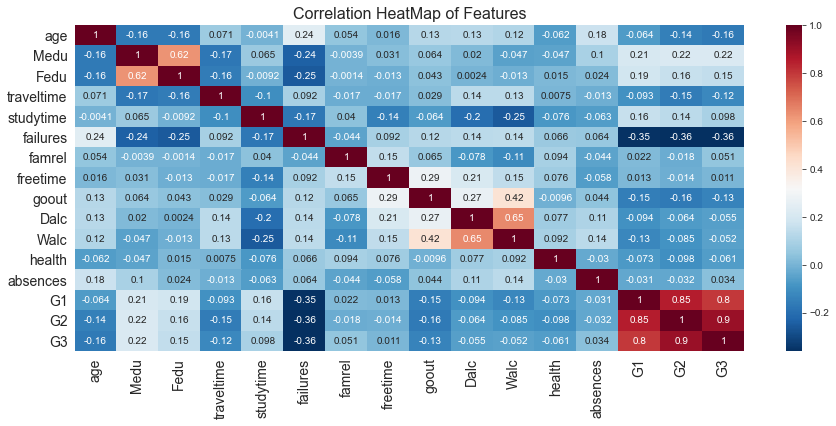

In [22]:
plt.figure(figsize = (15,6))
ax = sns.heatmap(data.corr(), cmap='RdBu_r', annot=True)
ax.set_title("Correlation HeatMap of Features", fontsize = 16)
ax.set_xticklabels(ax.get_xticklabels(),fontsize = 14, rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)
plt.show()

Sorting numerical features correlation with respect to our desired target vector 'G3'

In [23]:
data.corr()['G3'].sort_values()

failures     -0.360415
age          -0.161579
goout        -0.132791
traveltime   -0.117142
health       -0.061335
Dalc         -0.054660
Walc         -0.051939
freetime      0.011307
absences      0.034247
famrel        0.051363
studytime     0.097820
Fedu          0.152457
Medu          0.217147
G1            0.801468
G2            0.904868
G3            1.000000
Name: G3, dtype: float64

> From this results, we see that `G1` and `G2` are highly correlated to `G3`

# Feature Engineering

Since I will be performing a classification and regression task for this project, I will be creating a new binary label ot the final grade called `G3(binary)` used for classification models and using the datas `G3` for regression models.
> Where students who have a final grade of 10 or above `pass` and students who have a final grade less than 10 `fail`. 

In [24]:
data['G3(binary)'] = np.where(data['G3'] >= 10, 'Pass', 'Fail')
data.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(binary)
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,Fail
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,Fail
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,Pass
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,Pass
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,Pass
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,4,2,1,2,5,10,15,15,15,Pass
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,12,12,11,Pass
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,6,6,5,6,Fail
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,16,18,19,Pass
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,14,15,15,Pass


Since `G1` and `G2` which are period grades of a student and are highly correlated to the final grade `G3(binary)`, I will drop them to make it more difficult for the models to predict `G3(binary)`, such prediction is much more useful because we want to find other factors thats affect the students final grade. 

However, we will keep a datafame called `data_entire` that does not drop features `G1` and `G2` to just have a glance of how the models perform with this features for accuracy comparison

In [25]:
data_entire = data
data = data.drop(['G1', 'G2'], axis= 1)

## Prepare feature matrix "X" and target vector "y"

In [26]:
X = data.drop(['G3','G3(binary)'], axis=1)
y_class = data['G3(binary)']
y_reg = data['G3']

print("Feature Matrix for all tasks has a shape of ", X.shape)
print("Target Vector for classifications tasks has a shape of ", y_class.shape)
print("Target Vector for regression tasks has a shape of ", y_reg.shape)

Feature Matrix for all tasks has a shape of  (395, 30)
Target Vector for classifications tasks has a shape of  (395,)
Target Vector for regression tasks has a shape of  (395,)


### Dealing with categorical features

Encoding the Categorical features in our feature matrix `X` using `OneHotEncoder()` for norminal features, `OrdinalEncoder()` for ordinal features and scaling all numerical features using `StandardScaler()` all put together in a `ColumnTransformer()`

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

ct = ColumnTransformer(
    [("scaling", StandardScaler(), ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']),
     ("onehot", OneHotEncoder(sparse=False), ['Mjob', 'Fjob', 'reason', 'guardian']),
    ("ordinal", OrdinalEncoder(), ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])])

Encoding the target vector for classification Tasks using `LabelEncoder()`

In [28]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y_class_enc = enc.fit_transform(y_class)
enc.classes_

array(['Fail', 'Pass'], dtype=object)

## Creating the training and test data sets

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_class_enc, random_state = 123, test_size=0.25, stratify=y_class_enc)
print(f"X_train has a shape of {X_train.shape} and y_train has a shape of {y_train.shape}")
print(f"X_test has a shape of {X_test.shape} and y_test has a shape of {y_test.shape}")

X_train has a shape of (296, 30) and y_train has a shape of (296,)
X_test has a shape of (99, 30) and y_test has a shape of (99,)


>Applying the ColumnTransformer() on the feature matrix training and test data sets

In [30]:
X_train_scale = ct.fit_transform(X_train)
X_test_scale = ct.transform(X_test)
print(X_train_scale.shape)
print(X_test_scale.shape)

(296, 43)
(99, 43)


# Machine Learning Algorithms

## Compare and training models using 7 fold cross validation (Classification)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

models = [LogisticRegression(random_state=123), DecisionTreeClassifier(random_state=123), RandomForestClassifier(random_state=123),
          GradientBoostingClassifier(random_state=123),  BernoulliNB(), SVC()]

scores = []

for model in models:
    train, val = get_classifier_cv_score(model, X_train_scale, y_train, 'accuracy')
    scores.append((val, train, model.__class__.__name__ ))

for val, train, model in sorted(scores, reverse=True):
    print(f"{model} training score = {train:.3f}  validation score = {val:.3f}")

SVC training score = 0.826  validation score = 0.710
LogisticRegression training score = 0.779  validation score = 0.699
GradientBoostingClassifier training score = 0.979  validation score = 0.689
RandomForestClassifier training score = 1.000  validation score = 0.686
BernoulliNB training score = 0.713  validation score = 0.672
DecisionTreeClassifier training score = 1.000  validation score = 0.615


## Observations
The cross-validation above showed that the best 3 models are SVC, LogisticRegression and GradientBoostingClassifier which have validation scores of 0.710, 0.699, and 0.689 respectively which are fairly poor.

* SVC, BernoulliNB and LogisticRegression seems to be showing signs of `underfitting` since the training scores and the validation scores are somewhat similar
* RandomForestClassifier and DecisionTreeClassifier are showing signs of `overfitting` for getting maximum training scores and relatively low validation scores.
* GradientBoostingClassifier also shows signs of `overfitting` for getting almost a maximum training score and a relatively low validation score
> I will tune the parameters for each model by performing a grid search and find the parameters that give a sweet spot, based on the validation curve

## Hyperparameter tuning using grid search 

### Grid search for SVC

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid_svc = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

svc_grid = GridSearchCV(SVC(random_state=123), param_grid_svc, cv=7, n_jobs=1, return_train_score=True, scoring='accuracy')
svc_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=SVC(random_state=123), n_jobs=1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='accuracy')

In [33]:
print_grid_search_result(svc_grid)

Best parameters and their respective values are: 
C = 10
gamma = 0.01
Mean training score = 0.864
Mean validation score = 0.733


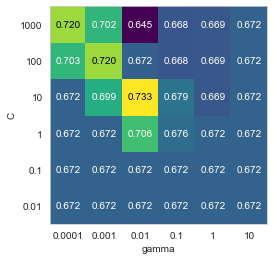

In [34]:
plot_grid_search_results(svc_grid)

## Observations

* After tunning the parameters, there is a slight increase in the training score (`from 0.826 to 0.864`) while the validation score also increase (`from 0.710 to 0.733`) the model is starting to show signs of `overfitting`, I will however accept the performance since the validation score did improve.

### Grid search for logistic regression

In [35]:
param_grid_logreg = {'tol': [0.001, 0.01, 0.1, 1, 10,100],
                    'C': [0.01, 0.1, 1, 10, 100,1000, 1000]}

logreg_grid = GridSearchCV(LogisticRegression(random_state=123), param_grid_logreg, cv=7, n_jobs=1, return_train_score=True, scoring='accuracy')
logreg_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=LogisticRegression(random_state=123), n_jobs=1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 1000],
                         'tol': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='accuracy')

In [36]:
print_grid_search_result(logreg_grid)

Best parameters and their respective values are: 
C = 0.1
tol = 0.001
Mean training score = 0.749
Mean validation score = 0.720


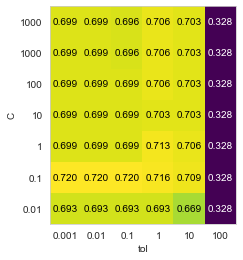

In [37]:
plot_grid_search_results(logreg_grid);

## Observations

* After tunning various numeric parameters of the logisticRegression() model, I was not able to find the best validation accuracy for example, only the `tol` parameter was important as I increased `C` in the selected parameters above, so i decided to use different parameters for the grid search for the LogisticRegression() model.

>I initially had to check the parameters associated with the model and also checked scikit learn for the calue of the parameters, some were boolean values some were also list of strigs for the model. So I chose the `multi-class` parameter which had a deafult value of `auto` 

In [38]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [39]:
param_grid_logreg2 = {'tol': [0.01, 0.1, 1, 10, 20, 25],
                     'multi_class':['auto', 'ovr', 'multinomial']}

logreg_grid2 = GridSearchCV(LogisticRegression(random_state=123), param_grid_logreg2, cv=7, n_jobs=1, return_train_score=True, scoring='accuracy')
logreg_grid2.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=LogisticRegression(random_state=123), n_jobs=1,
             param_grid={'multi_class': ['auto', 'ovr', 'multinomial'],
                         'tol': [0.01, 0.1, 1, 10, 20, 25]},
             return_train_score=True, scoring='accuracy')

In [40]:
print_grid_search_result(logreg_grid2)

Best parameters and their respective values are: 
multi_class = multinomial
tol = 10
Mean training score = 0.738
Mean validation score = 0.713


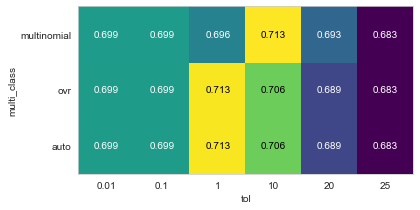

In [41]:
plot_grid_search_results(logreg_grid2);

## Observations

* After using the `multi-class` parameter, there was a change in the training score and validation score, which boosted the logisticRegression() to give me the best validation score by bumping it up `from 0.699 to 0.713` and reduces the training score `from 0.779 to 0.738`, I am going to take the parameters of this performance as acceptable for test evaluation as its going towards the 'sweet spot' of the validation curve

### Grid search for GradientBoostingClassifier

In [42]:
param_grid_gradb = {'n_estimators': [10, 50, 100, 200, 300, 500, 700],
                    'learning_rate': [0.001, 0.01, 0.1, 1.0]}

gradb_grid = GridSearchCV(GradientBoostingClassifier(random_state=123), param_grid_gradb, cv=7, n_jobs=1, return_train_score=True, scoring='accuracy')
gradb_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=GradientBoostingClassifier(random_state=123),
             n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [10, 50, 100, 200, 300, 500, 700]},
             return_train_score=True, scoring='accuracy')

In [43]:
print_grid_search_result(gradb_grid)

Best parameters and their respective values are: 
learning_rate = 0.1
n_estimators = 50
Mean training score = 0.912
Mean validation score = 0.699


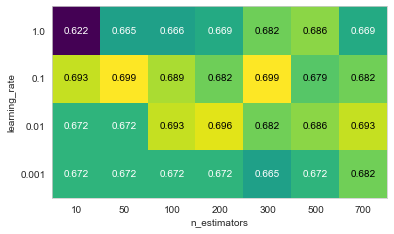

In [44]:
plot_grid_search_results(gradb_grid);

## Observations

* After tunning the parameters, there is a decrease in the training score (`from 0.979 to 0.912`) while the validation score did increase (`from 0.689 to 0.699`), I am going to take the parameters of this performance as acceptable for test evaluation as its also going towards the 'sweet spot' of the validation curve

## Results
### Training and Validation Scores of the three tuned (best) models

#### LogisticRegression
- Training score: 0.738
- Validation score: 0.713

#### SVC
- Training score: 0.864
- Validation score: 0.733

#### GradientBoostingClassifier
- Training score: 0.912 
- Validatioon score: 0.699

### Observation
> Even though these are the best performances for the classification tasks and they are low, this outcome was expected. As stated earlier, `G1` and `G2` are highly correlated to the final grades `G3` hence training the models without these 2 festures will be difficult. However, the models still tried to be accurate enough even without feature `G1` and `G2`. 

## Evaluate on Testing Data
### Training

In [45]:
models = [LogisticRegression(random_state=123, multi_class = 'multinomial', tol = 10),
          SVC(random_state=123, C = 10, gamma = 0.01),
          GradientBoostingClassifier(random_state = 123, learning_rate = 0.1, n_estimators = 50)]

for model in models:
    model.fit(X_train_scale, y_train)

### Testing

In [46]:
from sklearn.metrics import classification_report

for model in models:
    print(model.__class__.__name__ + ":")
    print(classification_report(y_test, model.predict(X_test_scale), target_names=["fail", "pass"]))
    print()

LogisticRegression:
              precision    recall  f1-score   support

        fail       0.63      0.36      0.46        33
        pass       0.74      0.89      0.81        66

    accuracy                           0.72        99
   macro avg       0.68      0.63      0.63        99
weighted avg       0.70      0.72      0.69        99


SVC:
              precision    recall  f1-score   support

        fail       0.42      0.24      0.31        33
        pass       0.69      0.83      0.75        66

    accuracy                           0.64        99
   macro avg       0.55      0.54      0.53        99
weighted avg       0.60      0.64      0.60        99


GradientBoostingClassifier:
              precision    recall  f1-score   support

        fail       0.50      0.42      0.46        33
        pass       0.73      0.79      0.76        66

    accuracy                           0.67        99
   macro avg       0.62      0.61      0.61        99
weighted avg       

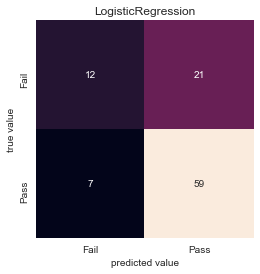

In [47]:
plot_confusion_matrix(y_test, models[0].predict(X_test_scale), enc.classes_, models[0].__class__.__name__);

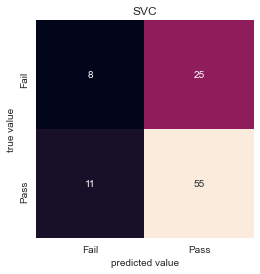

In [48]:
plot_confusion_matrix(y_test, models[1].predict(X_test_scale), enc.classes_, models[1].__class__.__name__);

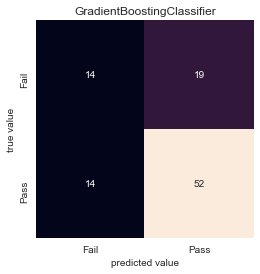

In [49]:
plot_confusion_matrix(y_test, models[2].predict(X_test_scale), enc.classes_, models[2].__class__.__name__);

# USING THE DATASET WITH FEATURE `G1` and `G2`

I will be showing the accuracy of the models using the highly correlated features `G1` and `G2` for comparison with when they were dropped

In [50]:
X_entire = data_entire.drop(['G3','G3(binary)'], axis=1)
X_entire.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,4,2,1,2,5,10,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,12,12
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,6,6,5
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,16,18
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,14,15


In [51]:
from sklearn.model_selection import train_test_split
X_train_entire, X_test_entire, y_train_entire, y_test_entire = train_test_split(X_entire, y_class_enc, random_state=45, test_size=0.2)

In [52]:
ct_2 = ColumnTransformer(
    [("scaling", StandardScaler(), ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']),
     ("onehot", OneHotEncoder(sparse=False), ['Mjob', 'Fjob', 'reason', 'guardian']),
    ("ordinal", OrdinalEncoder(), ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])])

In [53]:
X_train_entire_scale = ct_2.fit_transform(X_train_entire)
X_test_entire_scale = ct_2.transform(X_test_entire)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

models = [LogisticRegression(random_state=123), DecisionTreeClassifier(random_state=123), RandomForestClassifier(random_state=123), GradientBoostingClassifier(random_state=123),  BernoulliNB(), SVC(),]
scores = []

for model in models:
    train, val = get_classifier_cv_score(model, X_train_entire_scale, y_train_entire, 'accuracy')
    scores.append((val, train, model.__class__.__name__ ))

for val, train, model in sorted(scores, reverse=True):
    print(f"{model} training score = {train:.3f}  validation score = {val:.3f}")

LogisticRegression training score = 0.968  validation score = 0.930
RandomForestClassifier training score = 1.000  validation score = 0.918
GradientBoostingClassifier training score = 1.000  validation score = 0.896
SVC training score = 0.969  validation score = 0.873
DecisionTreeClassifier training score = 1.000  validation score = 0.864
BernoulliNB training score = 0.858  validation score = 0.838


## Observations

Right of the bat, we can see the validation scores for the 5 triained models are way higher than when we trained them without `G1` and `G2`

The best 3 models are LogisticRegression , RandomForestClassifier and GradientBoostingClassifier which have validation scores of 0.930, 0.918, and 0.896 respectively definitely higher than our first test.

* SVC, BernoulliNB, RandomForestClassifier and LogisticRegression seems to be showing signs of `underfitting` since the training scores and the validation scores are somewhat similar
* GradientBoostingClassifier and DecisionTreeClassifier are showing signs of `overfitting` for getting maximum training scores and relatively low validation scores.
> Now I will tune the parameters for for the top 3 models by performing a grid search and find the parameters that give a "sweet spot", based on the validation curve

## Hyperparameter tuning using grid search for enitre dataset

### Grid search for logistic regression

In [55]:
param_grid_logreg_entire = {'C': [0.01, 0.1, 1, 10, 20, 25],
                     'multi_class':['auto', 'ovr', 'multinomial']}

logreg_grid_entire = GridSearchCV(LogisticRegression(max_iter = 1000, random_state=123), param_grid_logreg_entire, cv=7, n_jobs=1, return_train_score=True, scoring='accuracy')
logreg_grid_entire.fit(X_train_entire_scale, y_train_entire)

GridSearchCV(cv=7,
             estimator=LogisticRegression(max_iter=1000, random_state=123),
             n_jobs=1,
             param_grid={'C': [0.01, 0.1, 1, 10, 20, 25],
                         'multi_class': ['auto', 'ovr', 'multinomial']},
             return_train_score=True, scoring='accuracy')

In [56]:
print_grid_search_result(logreg_grid_entire)

Best parameters and their respective values are: 
C = 10
multi_class = auto
Mean training score = 0.985
Mean validation score = 0.930


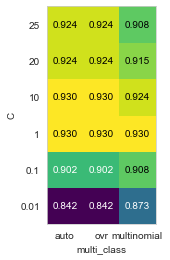

In [57]:
plot_grid_search_results(logreg_grid_entire);

## Observations

* After tunning the parameters, there is a increase in the training score (`from 0.968 to 0.985`) while the validation score remained the same (`at 0.930`), I would select the default parameters for this models as it is starting to show signs of `overfiting` and the validation score did not increase, this perfomance would not be acceptable for the test evaluation.

### Grid search for random forest classifier

In [58]:
param_grid_randf_entire = {'max_features': [11, 13, 15, 17, 20, 21],
                    'max_samples': [50, 100, 150, 200, 250, 270]}

randf_grid_entire = GridSearchCV(RandomForestClassifier(random_state=123), param_grid_randf_entire, cv=7, n_jobs=1, return_train_score=True, scoring='accuracy')
randf_grid_entire.fit(X_train_entire_scale, y_train_entire)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=123), n_jobs=1,
             param_grid={'max_features': [11, 13, 15, 17, 20, 21],
                         'max_samples': [50, 100, 150, 200, 250, 270]},
             return_train_score=True, scoring='accuracy')

In [59]:
print_grid_search_result(randf_grid_entire)

Best parameters and their respective values are: 
max_features = 20
max_samples = 250
Mean training score = 0.999
Mean validation score = 0.930


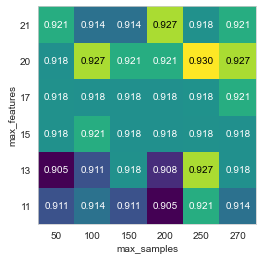

In [60]:
plot_grid_search_results(randf_grid_entire);

## Observations

* After tunning the parameters, there is a decrease in the training score (`from 1.000 to 0.999`) while the validation score did increase (`from 0.918 to 0.930`), I am going to take the parameters of this performance as acceptable for test evaluation as it is going towards the 'sweet spot' of the validation curve

### Grid search for gradient boosting classifier

In [61]:
param_grid_gradb_entire = {'n_estimators': [10, 50, 100, 200, 300, 500, 700],
                    'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100]}

gradb_grid_entire = GridSearchCV(GradientBoostingClassifier(random_state=123), param_grid_gradb_entire, cv=7, n_jobs=1, return_train_score=True, scoring='accuracy')
gradb_grid_entire.fit(X_train_entire_scale, y_train_entire)

GridSearchCV(cv=7, estimator=GradientBoostingClassifier(random_state=123),
             n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
                         'n_estimators': [10, 50, 100, 200, 300, 500, 700]},
             return_train_score=True, scoring='accuracy')

In [62]:
print_grid_search_result(gradb_grid_entire)

Best parameters and their respective values are: 
learning_rate = 1
n_estimators = 300
Mean training score = 1.000
Mean validation score = 0.924


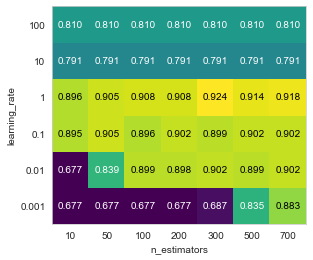

In [63]:
plot_grid_search_results(gradb_grid_entire);

## Observations

* After tunning the parameters, there was no change in the training score (`at 1.000`) while the validation score did increase (`from 0.896 to 0.924`), I will however accept the performance since the validation score did improve.

## Results for Entire Dataset
### Training and Validation Scores of the three tuned (best) models

#### LogisticRegression
- Training score: 0.968
- Validation score: 0.930

#### RandomForestClassifier
- Training score: 0.999
- Validation score: 0.930

#### GradientBoostingClassifier
- Training score: 1.000 
- Validatioon score: 0.924

### Observation
> We notice how the accuracry of the top 3 models are improved by including the `G1` and `G2` while testing the models due to the high correlation of the features to the final grades.

## Evaluate Entire Data on Testing Data
### Training

In [64]:
models = [LogisticRegression(random_state=123, max_iter = 1000),
          RandomForestClassifier(random_state=123, max_features = 20, max_samples = 250),
          GradientBoostingClassifier(random_state = 123, learning_rate = 1, n_estimators = 300)]

for model in models:
    model.fit(X_train_entire_scale, y_train_entire)

### Testing

In [65]:
from sklearn.metrics import classification_report

for model in models:
    print(model.__class__.__name__ + ":")
    print(classification_report(y_test_entire, model.predict(X_test_entire_scale), target_names=["fail", "pass"]))
    print()

LogisticRegression:
              precision    recall  f1-score   support

        fail       0.93      0.89      0.91        28
        pass       0.94      0.96      0.95        51

    accuracy                           0.94        79
   macro avg       0.93      0.93      0.93        79
weighted avg       0.94      0.94      0.94        79


RandomForestClassifier:
              precision    recall  f1-score   support

        fail       0.87      0.96      0.92        28
        pass       0.98      0.92      0.95        51

    accuracy                           0.94        79
   macro avg       0.93      0.94      0.93        79
weighted avg       0.94      0.94      0.94        79


GradientBoostingClassifier:
              precision    recall  f1-score   support

        fail       0.96      0.86      0.91        28
        pass       0.93      0.98      0.95        51

    accuracy                           0.94        79
   macro avg       0.94      0.92      0.93        79


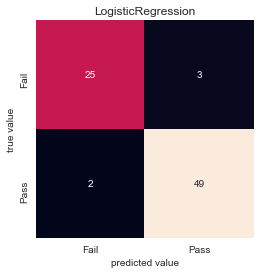

In [66]:
plot_confusion_matrix(y_test_entire, models[0].predict(X_test_entire_scale), enc.classes_, models[0].__class__.__name__);

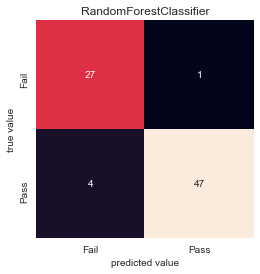

In [67]:
plot_confusion_matrix(y_test_entire, models[1].predict(X_test_entire_scale), enc.classes_, models[1].__class__.__name__);

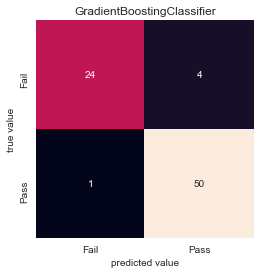

In [68]:
plot_confusion_matrix(y_test_entire, models[2].predict(X_test_entire_scale), enc.classes_, models[2].__class__.__name__);

Below are the final scores for the top three models for the dataset without `G1` and `G2` and with `G1` and `G2` after tuning them to their best hyperparameters and testing on the unseen test data:
However, due to the class imbalance, I will be using the macro average results from the classification report

## Final Results For Data Without `G1` and `G2`
### LogisticRegression
* Precision = 0.68
* Recall = 0.63
* F1-score = 0.63
* FP = 7
* FN = 21

### SVC
* Precision = 0.62
* Recall = 0.61
* F1-score = 0.61
* FP = 11
* FN = 25

### GradientBootingClassifier
* Precision = 0.55
* Recall = 0.54
* F1-score = 0.53
* FP = 14
* FN = 19

## Final Results For Data With `G1` and `G2`
### LogisticRegression
* Precision = 0.93
* Recall = 0.93
* F1-score = 0.93
* FP = 2
* FN = 3

### RandomForestClassifier
* Precision = 0.93
* Recall = 0.94
* F1-score = 0.93
* FP = 4
* FN = 1

### GradientBoostingClassifier
* Precision = 0.94
* Recall = 0.92
* F1-score = 0.93
* FP = 1
* FN = 4

# Interpretation
## Best model
It is clear that the results gotten when `G1` and `G2` were not included yielded low accuracy performances by the models, Their f1-scores are seperated by a 10% margin with the LogisticRegression classifier having the best f1-score of 0.63 and SVC being very close with a f1-score of 0.61, I will also look at the false negative and false positive predictions for these two models to make further conclusion. For these scenario, both false positive and negative predictions for the LogisticRegression model is lower than SVC further concluding that the `LogisticRegression` model works best when `G1` and `G2` are not included as features in our dataset.

With the feature `G1` and `G2` included, we get very interesting results of the models having the exact f1-score of 0.93 which is quite impresive. However, I still cannot tag the best model with the entire dataset when they all have the exact f1-score. I will look the the false negative and positive predictions as I did in the previous test, to select the best model. The RandomForestClassifier has more false positive than false negative which means more students falsey passed, which means student who do not deserve the grade get a pass score which would not be a good scenario based of the situaition (Ranking a school based on student grades, Students getting promoted to the next class with limited seat space, etc.). Similarly, with the GradientBoostingClassifier has more false negative than false positive which means more students falsey failed when they did actually pass, which means student who actually deserve the pass grade were failed which would not be a good scenario based of the situaition (Students relying on their math final score grade to bump up their overall GPA, etc.). With LogisticRegression we get a balance of the predicted False negative and positive of 3 and 2 respectively, which is better than having more falsey on one side of the class than the other. I will conlude that `LogisticRegression` model also works best when `G1` and `G2` are also included as features in our dataset.

# Reflection
I learned quite a lot from this mini project. Having the mixture of categorical and numerical data helped me get more of a feel for what is required for encoding features in datasets (preprocessing). I also feel much more comfortable grid searching and interpreting the results from those grid searches. 

With regards to the proposal, I stated I will use lab 2, but I ended using both lab 2 and lab 3 for this mini project, I followed the general structure/flow of that lab to explore this data and train machine learning models for the final grades prediction. I also stated using both classification and regression models for the mini project which would be more interesting comparing if classification or regression works better for this dataset, I had already created a scoring function to get the negative root mean square error which is a score for regressor models and also decided to use the default `G3` column in the initial dataset as my target vector which I called `y_reg`. However adding regressor models will deviate from this project being more than a mini project. So definitely using regressor models for the dataset will be something to definitely do in the near future.

In summary, I feel I explored and created 3 models that have good performance at predicting students final math grade, provided we can collect all the data used as features for the dataset, including `G1` and `G2`. This was a great learning experience and I look forward to exploring more datasets and machinelearning models in the future!
